### Objectives of this notebook:
- display output from ABRM
- perform analysis on output. eg. feature importance and model selection
- in console do: jupyter nbconvert --to="python" '.\Postprocessing.ipynb'
- this will upload the file in pure python format

In [1]:
import numpy as np
import pandas as pd
import plotly.io as pio
import ABRM_functions

pio.renderers.default = "notebook"

### Import data
- one df with FD performance of each particle  
- one df with associated particle position  
- one dicct with initial setup that would allow reproduction of results

In [2]:
dataset = ["2020_05_11_20_07"]
misfit_tolerance = 0.1

df_performance,df_position,setup_all, FD_targets = ABRM_functions.read_data(dataset)

print("Number of models and parameters:")
display(df_position.shape)
print("Number of particles:")
display(df_position.particle_no.max()+1)
print("Number of Iterations:")
display(df_position.iteration.max()+1)
display(df_performance.head())
display(df_position.head())

Number of models and parameters:


(90, 15)

Number of particles:


18

Number of Iterations:


5

EV        tD         F       Phi        LC  particle_no    misfit  \
0  0.000000  0.000000  0.000000  0.000000  0.242036            0  0.245933   
1  0.544231  0.544342  0.013326  0.007143  0.242036            0  0.245933   
2  0.554235  0.554546  0.026322  0.014286  0.242036            0  0.245933   
3  0.562444  0.563032  0.039102  0.021428  0.242036            0  0.245933   
4  0.568869  0.569762  0.051714  0.028571  0.242036            0  0.245933   

   iteration           dataset  
0          0  2020_05_11_20_07  
1          0  2020_05_11_20_07  
2          0  2020_05_11_20_07  
3          0  2020_05_11_20_07  
4          0  2020_05_11_20_07

P32  n_sides  elongation_ratio     shape      scale   mean_dip  \
0  1.213874      5.0          1.092587  2.904947  46.659690  70.790694   
1  0.346551      9.0          1.327519  2.511905  35.337272  69.821654   
2  1.244385      4.0          2.925413  3.758865   9.463236  12.935501   
3  1.113372      6.0          0.643165  2.928001  67.636166  22.798306   
4  1.046026      6.0          2.764385  4.065836  45.960516  72.567061   

   mean_dip_azimuth  concentration  aperture_mean  aperture_std    misfit  \
0         36.532999      58.853649       0.000648  1.395400e-05  0.245933   
1         48.403241      94.217292       0.000242  1.333440e-05  0.336256   
2         53.200996      80.641345       0.000344  1.207700e-05  0.359786   
3         64.313418       4.610366       0.000068  6.626000e-07  0.255082   
4         88.719209      59.898246       0.000669  1.348470e-05  0.484516   

   particle_no        LC  iteration           dataset  
0            0  0.242036          0  2020_05_11_20_07  
1            1  0.183941          0  2020_05_11_20_07  
2            2  0.168325          0  2020_05_11_20_07  
3            3  0.236104          0  2020_05_11_20_07  
4            4  0.087593          0  2020_05_11_20_07

### Plot performance

In [3]:
ABRM_functions.plot_performance(df_performance,df_position,FD_targets,setup_all,dataset,misfit_tolerance)

### Boxplots parameters
explore if ranges of parameters need potential modifications

In [4]:
ABRM_functions.plot_box(df = df_position,setup_all = setup_all, dataset = dataset)

### Histogram Paramters

In [5]:
ABRM_functions.plot_hist(df = df_position,setup_all = setup_all, dataset = dataset,misfit_tolerance = None)

### Histograms for best models parameters

In [6]:
ABRM_functions.plot_hist(df = df_position,setup_all = setup_all, dataset = dataset,misfit_tolerance = misfit_tolerance)

### Cluster best models with UMAP and HDBSCAN

In [10]:
df_best = ABRM_functions.best_model_selection_UMAP_HDBSCAN(df = df_position,dataset =dataset,setup_all = setup_all,
                                                           n_neighbors= 2, min_cluster_size=2, misfit_tolerance = misfit_tolerance,
                                                           use_UMAP = True)

### Build best performing models for flow simulation

In [8]:
best_models = ABRM_functions.save_best_clustered_models(df_best = df_best, datasets = dataset)

### Feature importance - model explainability

In [13]:
import shap
from sklearn.ensemble import RandomForestRegressor


In [14]:
columns = setup_all[dataset[0]]["columns"]
X_train = df_position[columns]
Y_train = df_position.LC

In [15]:
# load JS visualization code to notebook
shap.initjs()

In [16]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


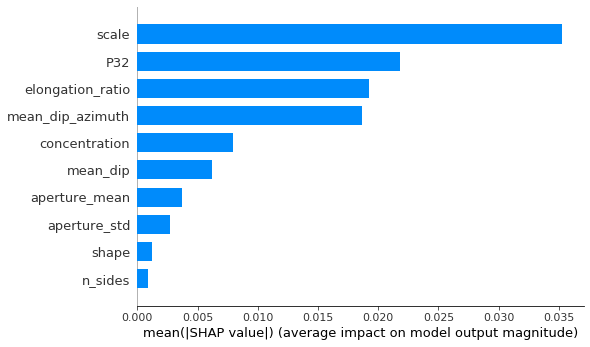

In [17]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [18]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[80,:], X_train.iloc[80,:])

In [19]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

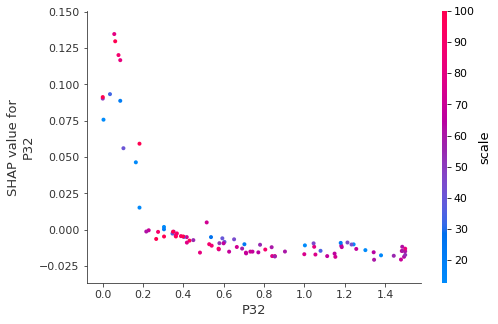

In [20]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("P32", shap_values, X_train)

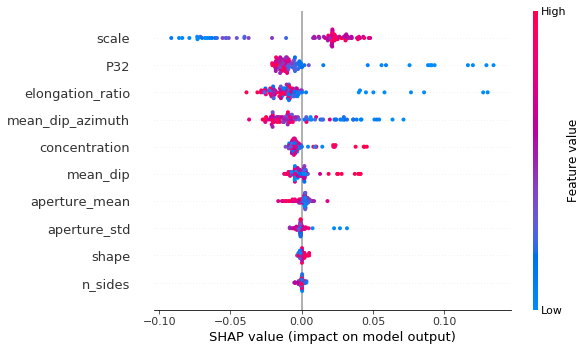

In [21]:
shap.summary_plot(shap_values, X_train)
